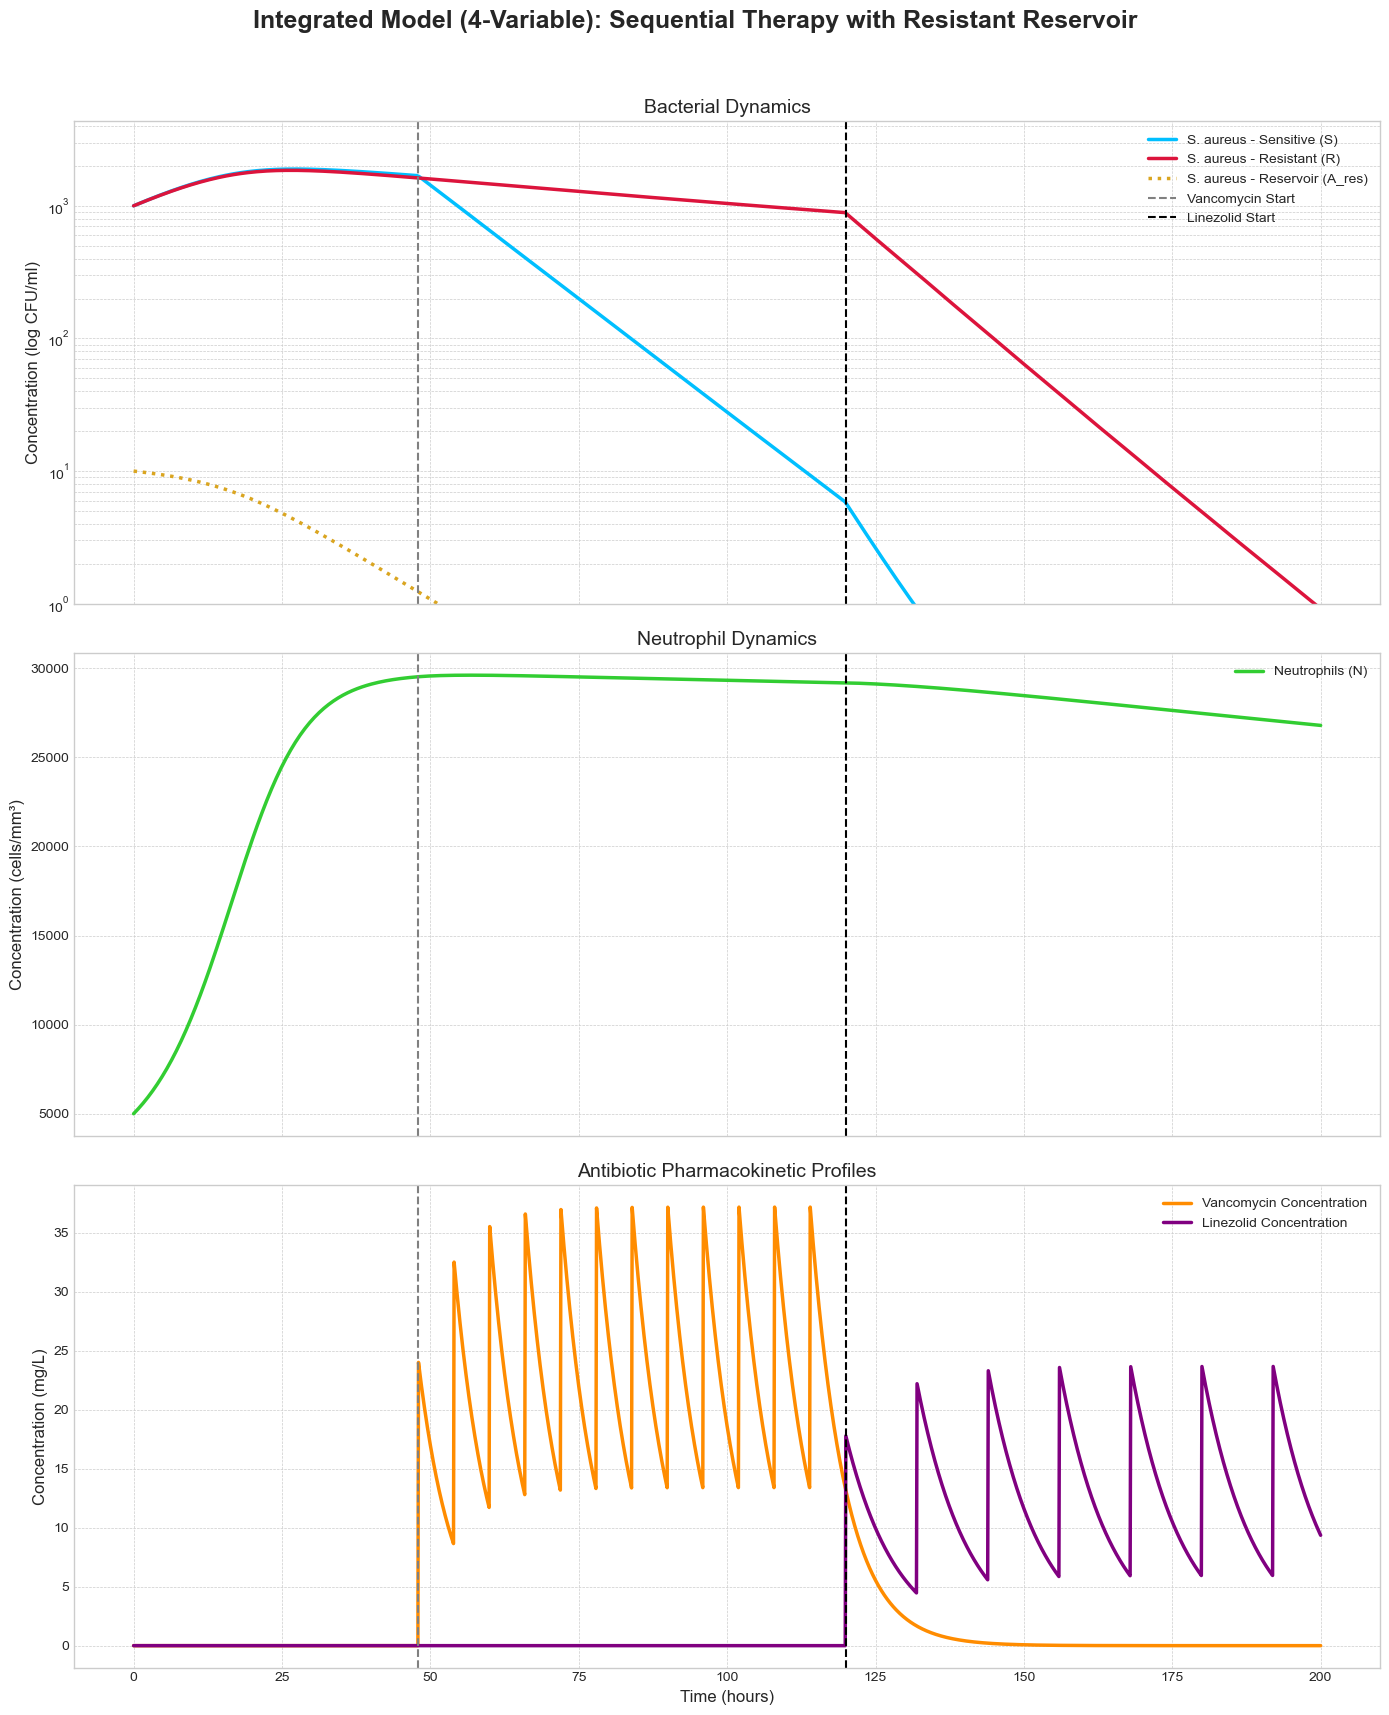

Simulation complete. Plot saved as 'integrated_model_4var_with_reservoir_plot.png'


In [8]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# --- 1. Pharmacokinetic Model Class ---
class PharmacokineticModel:
    """
    A class to manage pharmacokinetic parameters and calculate drug concentration profiles
    over time for a simple one-compartment model with repeated bolus doses.
    """
    def __init__(self):
        # Vancomycin parameters
        self.van_dose = 1200      # Dose in mg
        self.van_interval = 6     # Dosing interval in hours
        self.van_duration = 72    # Total duration of therapy in hours
        self.van_ke = 0.173       # Elimination rate constant (1/h), based on ~4h half-life
        self.van_volume = 50      # Distribution volume in Liters (L)

        # Linezolid parameters
        self.lzd_dose = 800       # Dose in mg
        self.lzd_interval = 12    # Dosing interval in hours
        self.lzd_duration = 192   # Total duration of therapy in hours
        self.lzd_ke = 0.116       # Elimination rate constant (1/h), based on ~6h half-life
        self.lzd_volume = 45      # Distribution volume in Liters (L)

    def calculate_concentrations(self, drug_type, total_sim_time_h, start_time_h=0):
        """
        Calculates the concentration of a drug over a given simulation time.

        Args:
            drug_type (str): 'vancomycin' or 'linezolid'.
            total_sim_time_h (float): The total duration for the simulation in hours.
            start_time_h (float): The time (in hours) when the drug administration begins.

        Returns:
            tuple: A tuple containing the time array (in hours) and the concentrations array (in mg/L).
        """
        if drug_type == 'vancomycin':
            dose, interval, duration, ke, volume = self.van_dose, self.van_interval, self.van_duration, self.van_ke, self.van_volume
        else:  # linezolid
            dose, interval, duration, ke, volume = self.lzd_dose, self.lzd_interval, self.lzd_duration, self.lzd_ke, self.lzd_volume

        # High-resolution time vector for smooth PK curves
        t = np.linspace(0, total_sim_time_h, int(total_sim_time_h * 10) + 1)
        concentrations = np.zeros_like(t)

        # Calculate the time when the drug therapy ends
        end_drug_time = start_time_h + duration

        # Add the effect of each dose
        for dose_time in np.arange(start_time_h, end_drug_time, interval):
            # Mask for times after the current dose is administered
            dose_mask = t >= dose_time
            # Add the concentration resulting from this dose to all subsequent time points
            concentrations[dose_mask] += (dose / volume) * np.exp(-ke * (t[dose_mask] - dose_time))

        # Ensure concentration is zero before therapy starts
        concentrations[t < start_time_h] = 0.0

        return t, concentrations

# --- 2. Combined Immune and Pharmacodynamic ODE Model (4-Variable) ---
def immune_and_pd_model(y, t_days, params, van_interp, lzd_interp):
    """
    Defines the system of ODEs for two bacterial populations (sensitive and resistant),
    a resistant reservoir, and a single-class immune response (macrophages).
    The reservoir is not affected by antibiotics.

    Args:
        y (list): A list of the current values of the state variables:
            - y[0] = S: Concentration of vancomycin-sensitive S. aureus.
            - y[1] = R: Concentration of vancomycin-resistant S. aureus, sensitive to Linezolid.
            - y[2] = A_res: Concentration of resistant S. aureus in a protected reservoir.
            - y[3] = M: Concentration of neutrophils.
        t_days (float): The current time in days (from the ODE solver).
        params (dict): A dictionary of model parameters.
        van_interp (function): An interpolation function for vancomycin concentration.
        lzd_interp (function): An interpolation function for linezolid concentration.

    Returns:
        list: A list of the derivatives for each state variable [dSdt, dRdt, dA_res_dt, dNdt].
    """
    # Unpack the 4 state variables
    S, R, A_res, N = y
    t_hours = t_days * 24

    # Get antibiotic concentrations from the interpolation functions
    V = van_interp(t_hours)
    L = lzd_interp(t_hours)

    # Ensure state variables and concentrations do not go below zero
    S, R, A_res, N = max(0, S), max(0, R), max(0, A_res), max(0, N)
    V, L = max(0, V), max(0, L)

    # Total bacterial load in the main infection site, which stimulates the immune response
    A_total_infection = S + R


    h_V = 1.0
    h_L = 1.0
    
    # --- Pharmacodynamic (PD) Effects ---
    # Linezolid inhibits bacterial growth in the main compartment
    linezolid_inhibition = (params['Imax_L'] * (L**h_L))/ ((params['EC50_L']**h_L) + (L**h_L))
   

    # Vancomycin actively kills bacteria
    vancomycin_kill_rate = (params['kmax_V'] * (V**h_V)) / ((params['EC50_V']**h_V) + (V**h_V))

    # --- System of Ordinary Differential Equations (ODEs) ---

    # Growth term with a shared carrying capacity for the main infection
    logistic_factor = (1 - A_total_infection / params['B_max'])

    # Immune kill term: Macrophages (M) attack both strains
    immune_kill_S = params['kill_N'] * N * S
    immune_kill_R = params['kill_N'] * N * R

    # Equation for sensitive bacteria (S)
    dSdt = (params['rho_S'] * S * logistic_factor) - (params['delta'] * S) - immune_kill_S - (vancomycin_kill_rate * S) - linezolid_inhibition * S

    # Equation for resistant bacteria (R), seeded by the reservoir
    dRdt = (params['rho_R'] * R * logistic_factor) - (params['delta'] * R) - (linezolid_inhibition * R) - immune_kill_R + (params['f_r_b'] * A_res) - (params['f_b_r'] * R)
    

    # --- Equation for the Resistant Reservoir (Unaffected by drugs) ---
    reservoir_growth = params['rho_res'] * A_res * (1 - A_res / params['k_res'])
    dA_res_dt = reservoir_growth - (params['delta_res'] * A_res) - (params['f_r_b'] * A_res) - params['kill_N']* N * A_res
    #assumption resevoir macrophage kill rate = blood macrophage kill rate
    
    # Equation for neutrophil dynamics (N)
    dNdt = params['rho_N'] * N * (A_total_infection) * (1 - N / params['N_MAX']) -params['delta_N'] * N
    return [dSdt, dRdt, dA_res_dt, dNdt]

# --- 3. Simulation Setup ---
total_simulation_time_h = 200.0
pk_model = PharmacokineticModel()

# Define the sequential treatment schedule (in hours from start of simulation)
vanco_start_time_h = 48.0
# Linezolid starts immediately after vancomycin therapy ends
linezolid_start_time_h = vanco_start_time_h + pk_model.van_duration

# Pre-calculate the antibiotic concentration profiles for the entire simulation
t_van_h, conc_van = pk_model.calculate_concentrations('vancomycin', total_simulation_time_h, start_time_h=vanco_start_time_h)
t_lzd_h, conc_lzd = pk_model.calculate_concentrations('linezolid', total_simulation_time_h, start_time_h=linezolid_start_time_h)

# Create interpolation functions to get drug concentration at any time t
van_concentration_func = interp1d(t_van_h, conc_van, bounds_error=False, fill_value=0)
lzd_concentration_func = interp1d(t_lzd_h, conc_lzd, bounds_error=False, fill_value=0)

# --- 4. Run the Full Simulation ---
params = {
    # Bacterial parameters
    'rho_S': 1.47,       # growth rate sensitive
    'rho_R': 1.47,       # growth rate resistant
    'B_max': 4e12,          # Carrying capacity (CFU/ml)
    'delta': 0.179,          # Sensitive and Resistant Natural death rate (1/day)
    # Immune parameters
    'kill_N': 5e-5,     # Kill rate by neutrophils
    'rho_N': 1e-3,         # Growth rate of neutrophils
    'N_MAX': 30000,       # Max macrophage population
    'delta_N': 0.03,         # Decay rate of neutrophils
    # Antibiotic PD parameters
    'kmax_V': 1.74,     # Max kill rate for Vancomycin
    'Imax_L': 1.97,     # Max growth inhibition for Linezolid
    'EC50_V': 0.384,      # Vancomycin concentration for 50% max effect (mg/L)
    'EC50_L': 0.245,      # Linezolid concentration for 50% max effect (mg/L)
    # Reservoir parameters
    'rho_res': 0.1,     # Growth rate of reservoir bacteria (1/day)
    'k_res': 1e4,       # Carrying capacity of reservoir (CFU/ml)
    'delta_res': 0.1,  # Natural death rate of reservoir bacteria (1/day)
    'f_r_b': 0.02,     # transfer rate from reservoir compartment to blood compartment
    'f_b_r': 0.02      # transfer rate from blood compartment to resevoir compartment
}

# Initial conditions for the 4 state variables: [S, R, A_res, N]
y0 = [1e3, 1e3, 1e1, 5000]

# Time vector for the ODE solver (in days)
t_sim_days = np.linspace(0, total_simulation_time_h / 24.0, 500)

# Solve the ODE system
solution = odeint(immune_and_pd_model, y0, t_sim_days, args=(params, van_concentration_func, lzd_concentration_func))
#print(solution[:, 3])
# --- 5. Plotting Results ---
t_plot_h = t_sim_days * 24

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
fig.suptitle('Integrated Model (4-Variable): Sequential Therapy with Resistant Reservoir', fontsize=18, fontweight='bold')

# Plot 1: Bacterial Dynamics
ax1.plot(t_plot_h, solution[:, 0], label='S. aureus - Sensitive (S)', color='deepskyblue', linewidth=2.5)
ax1.plot(t_plot_h, solution[:, 1], label='S. aureus - Resistant (R)', color='crimson', linewidth=2.5)
ax1.plot(t_plot_h, solution[:, 2], label='S. aureus - Reservoir (A_res)', color='goldenrod', linestyle=':', linewidth=2.5)
ax1.set_title('Bacterial Dynamics', fontsize=14)
ax1.set_ylabel('Concentration (log CFU/ml)', fontsize=12)
ax1.set_yscale('log')
ax1.set_ylim(bottom=1) # Set a bottom limit for the log scale
ax1.axvline(x=vanco_start_time_h, color='gray', linestyle='--', label='Vancomycin Start')
ax1.axvline(x=linezolid_start_time_h, color='black', linestyle='--', label='Linezolid Start')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 2: neutrophil Dynamics
ax2.plot(t_plot_h, solution[:, 3], label='Neutrophils (N)', color='limegreen', linewidth=2.5)
ax2.set_title('Neutrophil Dynamics', fontsize=14)
ax2.set_ylabel('Concentration (cells/mm³)', fontsize=12)

ax2.axvline(x=vanco_start_time_h, color='gray', linestyle='--')
ax2.axvline(x=linezolid_start_time_h, color='black', linestyle='--')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 3: Antibiotic Pharmacokinetics
ax3.plot(t_van_h, conc_van, label='Vancomycin Concentration', color='darkorange', linewidth=2.5)
ax3.plot(t_lzd_h, conc_lzd, label='Linezolid Concentration', color='purple', linewidth=2.5)
ax3.set_title('Antibiotic Pharmacokinetic Profiles', fontsize=14)
ax3.set_xlabel('Time (hours)', fontsize=12)
ax3.set_ylabel('Concentration (mg/L)', fontsize=12)
ax3.axvline(x=vanco_start_time_h, color='gray', linestyle='--')
ax3.axvline(x=linezolid_start_time_h, color='black', linestyle='--')
ax3.legend()
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)

# Final formatting
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('integrated_model_4var_with_reservoir_plot.png', dpi=300)
plt.show()
#plt.close()

print("Simulation complete. Plot saved as 'integrated_model_4var_with_reservoir_plot.png'")

### Model Summary

This notebook implements an integrated pharmacokinetic (PK) and pharmacodynamic (PD) model simulating the dynamics of vancomycin-sensitive and resistant *S. aureus* bacteria, a resistant bacterial reservoir, and a macrophage immune response. The model incorporates a sequential antibiotic treatment strategy with vancomycin followed by linezolid.

**1. Pharmacokinetic Model:**

A simple one-compartment PK model is used for both vancomycin and linezolid to simulate their concentration profiles over time following repeated bolus doses. The model considers:

*   **Dose:** The amount of drug administered.
*   **Interval:** The time between doses.
*   **Duration:** The total time the drug is administered.
*   **Elimination Rate Constant (ke):** The rate at which the drug is removed from the body.
*   **Distribution Volume:** The apparent volume in which the drug is distributed.

**2. Combined Immune and Pharmacodynamic ODE Model (4-Variable):**

This part of the model is defined by a system of four ordinary differential equations (ODEs) that describe the rates of change for the following state variables:

*   **S:** Concentration of vancomycin-sensitive *S. aureus*.
*   **R:** Concentration of vancomycin-resistant *S. aureus*.
*   **A_res:** Concentration of resistant *S. aureus* in a protected reservoir (unaffected by antibiotics in the main compartment).
*   **M:** Concentration of macrophages (immune cells).

The ODEs incorporate the following processes:

*   **Bacterial Growth:** Logistic growth for both sensitive and resistant bacteria in the main infection site, limited by a carrying capacity. The growth of sensitive and resistant bacteria in the main compartment is inhibited by linezolid.
*   **Bacterial Death:** Natural death rates for all bacterial populations.
*   **Antibiotic Kill:** Vancomycin actively kills sensitive bacteria based on its concentration and PD parameters.
*   **Immune Kill:** Macrophages kill both sensitive and resistant bacteria in the main compartment.
*   **Reservoir Dynamics:** The resistant reservoir has its own growth and death rates and can transfer resistant bacteria to the main infection site. Resistant bacteria can transfer from blood compartment to the resevoir compartment.
*   **Macrophage (monocyte) Dynamics:** Macrophages grow in response to the total bacterial load in the main infection site and have a decay rate.

### Model Parameters

The following parameters are used in the ODE model:

**Bacterial Parameters:**

*   `rho_S`:  growth rate sensitive
*   `rho_R`:  growth rate resistant
*   `k_Sys`: Carrying capacity of *S. aureus* in the main compartment (CFU/ml).
*   `delta`: Natural death rate of *S. aureus* in the main compartment (1/day).

**Immune Parameters:**

*   `kill_M`: Kill rate of bacteria by macrophages.
*   `rho_M`: Growth rate of macrophages.
*   `M_MAX`: Maximum macrophage population.
*   `delta_M`: Decay rate of macrophages.


**Antibiotic Pharmacodynamic (PD) Parameters:**

*   `kmax_V`: Maximum kill rate for Vancomycin.
*   `EC50_V`: Vancomycin concentration for 50% of maximum effect (mg/L).
*   `EC50_L`: Linezolid concentration for 50% of maximum effect (mg/L).
*   `h_V`: Hill coefficient for Vancomycin (steepness of the dose-response curve).
*   `h_L`: Hill coefficient for Linezolid (steepness of the dose-response curve).
*   `Imax_L`: Maximum growth inhibition for Linezolid.



**Reservoir Parameters:**

*   `rho_res`: Growth rate of bacteria in the reservoir (1/day).
*   `k_res`: Carrying capacity of the reservoir (CFU/ml).
*   `delta_res`: Death rate of bacteria in the reservoir (1/day).
*   `f_r_b`: transfer rate of resistant bacteria from the reservoir to the blood compartment.
*   `f_b_r` : transfer rate or resistant bacteria from blood compartment to resevoir compartment